### Load the modules we'll need

In [1]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('fivethirtyeight')
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Data Exploration: How do bulk RNA-seq and scRNA-seq data differ?

Today we'll introduce single-cell RNA-seq data and show how it can be used. First, however, we'll see how a typical scRNA-seq data set compares to the bulk RNA-seq data we're more familiar with. There are a few key differences. First, bulk samples have many more reads than single-cell samples and have many more genes captured in a single experiment. This is due to the fact that a single bulk sample consists of many, many cells and thus has more RNA available to be captured. Related is the fact that expression values are much noisier in scRNA-seq data because each observation contains one cell rather than values averaged over many cells as in bulk. There is also additional technial variation in certain protocols because of the need to amplify RNA more aggressively because there is less to start with. We'll demonstrate some of these facts using bulk RNA-seq and scRNA-seq generated in the same experiment and tissue (spleen in the Tabula Muris). We'll focus on cells in the immune system (B, T, and natural killer (NK) cells).

First, we'll load the data. These include metadata for the single cells as well as the expression data for the bulk and single-cell experiments. You don't need to change anything in these cells, but be sure to examine what's being done in the respective normalizations. Consider why they might be a bit different. These data have been partially pre-processed to remove non-expressed genes and ensure that the two data sets have the same genes included. This removes the need for tedious indexing and reduces the file sizes to help save our kernels! However, one side-effect is that we will have lower levels of sparsity than you would encounter with a raw data set.

In [2]:
# Load metadata for single cells
sc_meta = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab07/spleen_meta_sc.csv', sep = ',', header = 0).set_index('index').rename(columns ={'Unnamed: 0':'Sample Num'})

In [3]:
# Load bulk expression data and normalize it
bulk_data = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab07/bulk_data.csv', sep = ',', header = 0).set_index('Gene')
bulk_total_med = bulk_data.sum().median()
bulk_sample_med = bulk_data.median()
bulk_data_norm = bulk_data / bulk_sample_med * bulk_total_med

In [4]:
# Load single-cell expression data and normalize it
scRNA_data_pre = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab07/cell_data.csv', sep = ',', header = 0).set_index('Gene')
# These data were on log scale so let's go back to counts
sc_data = (2 ** scRNA_data_pre - 1)
sc_total_med = sc_data.sum().median()
sc_data_norm = sc_data / sc_data.sum() * sc_total_med

Now, let's look at how many genes have non-zero values for each sample/cell. We say these genes are "expressed" in the corresponding sample. You should notice a marked difference between the two data types.

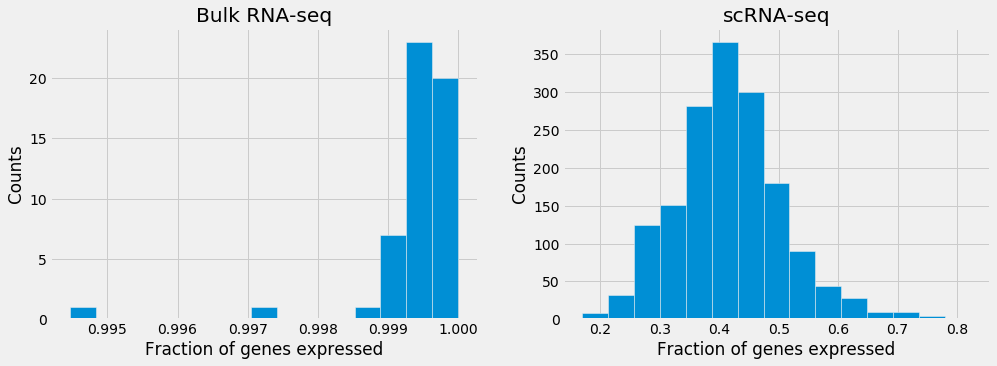

In [5]:
# Compare histograms of the number of genes "expressed" per bulk sample and per single cell
plt.figure(figsize=(15,5))

plt.subplot(121)
avg_genes_per_sample_bulk = (bulk_data_norm > 0).mean()
plt.hist(avg_genes_per_sample_bulk, bins = 15)
plt.title("Bulk RNA-seq") 
plt.xlabel('Fraction of genes expressed')
plt.ylabel('Counts')

plt.subplot(122)
avg_genes_per_sample_sc = (sc_data_norm > 0).mean()
plt.hist(avg_genes_per_sample_sc, bins = 15)
plt.title("scRNA-seq") 
plt.xlabel('Fraction of genes expressed')
plt.ylabel('Counts')

plt.show()

Let's consider the same question from a slightly different angle. For individual genes, how many samples/cells express that gene? This should only require a minor modification to your previous code.

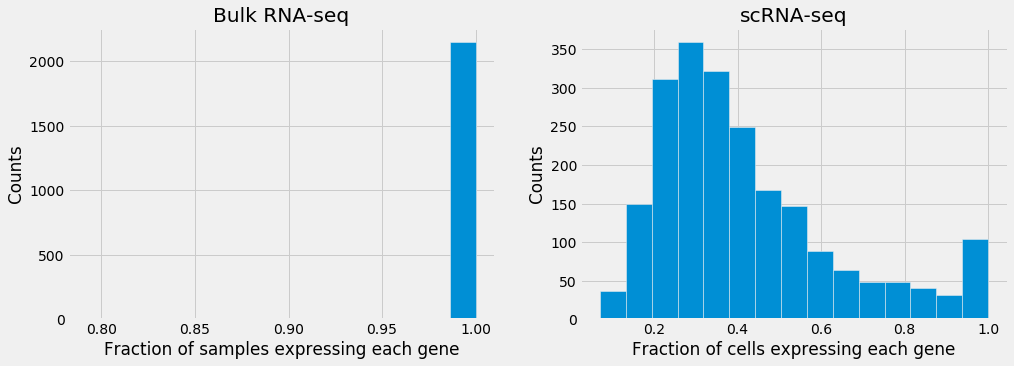

In [6]:
# Compare histograms of the number of samples or cells which express individual genes
plt.figure(figsize=(15,5))

plt.subplot(121)
avg_samples_per_gene_bulk = (bulk_data_norm > 0).mean(axis = 1)
plt.hist(avg_samples_per_gene_bulk, bins = 15)
plt.title("Bulk RNA-seq") 
plt.xlabel('Fraction of samples expressing each gene')
plt.ylabel('Counts')

plt.subplot(122)
avg_cells_per_gene_sc = (sc_data_norm > 0).mean(axis = 1)
plt.hist(avg_cells_per_gene_sc, bins = 15)
plt.title("scRNA-seq") 
plt.xlabel('Fraction of cells expressing each gene')
plt.ylabel('Counts')

plt.show()

Finally, let's see what fraction of our entries are zero. This is referred to as the "sparsity" of the data set.

In [7]:
# Compute and display the sparsity of each data matrix. That is, the fraction of the entries which are 0.
sparsity = [(bulk_data_norm == 0).sum().sum() / bulk_data_norm.size,
            (sc_data_norm == 0).sum().sum() / sc_data_norm.size]

sparsity

[0.0005047691986353826, 0.5823282957094277]

Having investigated the sparsity patterns of our data, let's compute a few summary statistics. Let's do the mean, standard deviation, and coefficient of variation. These tell us about the centrality, spread, and "noise-to-signal" ratio. As you may suspect, there should be more noise in your scRNA-seq data.

In [8]:
# Compute the mean and standard deviation of expression levels for each gene in both matrices. 
# Use these values to compute the coefficients of variation (sd/mean)
bulk_gene_means = np.log2(bulk_data_norm+1).mean(axis = 1)
sc_gene_means = np.log2(sc_data_norm+1).mean(axis = 1)

bulk_gene_sds = np.log2(bulk_data_norm+1).std(axis = 1)
sc_gene_sds = np.log2(sc_data_norm+1).std(axis = 1)

bulk_gene_cvs = bulk_gene_sds / bulk_gene_means
sc_gene_cvs = sc_gene_sds / sc_gene_means

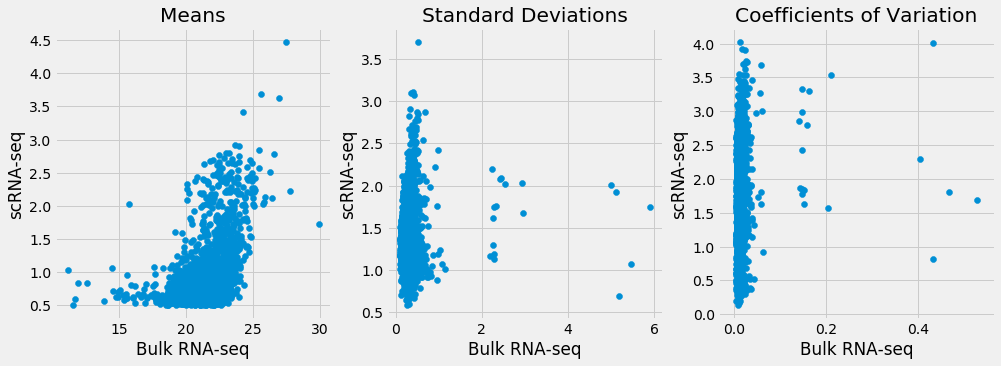

In [9]:
# Plot the means, standard deviations, and coefficients of variation for each gene in the single-cell and bulk
# datasets. 
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.scatter(bulk_gene_means, sc_gene_means)
plt.title('Means') 
plt.xlabel('Bulk RNA-seq')
plt.ylabel('scRNA-seq')

plt.subplot(132)
plt.scatter(bulk_gene_sds, sc_gene_sds)
plt.title('Standard Deviations') 
plt.xlabel('Bulk RNA-seq')
plt.ylabel('scRNA-seq')

plt.subplot(133)
plt.scatter(bulk_gene_cvs, sc_gene_cvs)
plt.title('Coefficients of Variation') 
plt.xlabel('Bulk RNA-seq')
plt.ylabel('scRNA-seq')
plt.show()

# Data Analysis

We've seen that there are some obvious differences in how typical scRNA-seq and bulk RNA-seq data sets behave. This leads to some differences in the most common analysis tools, a fact compounded by the disparate set of tasks we usually want to perform. Whereas bulk experiments are often used for differential expression between conditions, scRNA-seq is utilized for the identification and interrogation of different cell types. Let's walk through a standard scRNA-seq analysis now.

In [10]:
# We'll start with PCA. Apply the built-in scaler and then perform PCA on this matrix.
x = StandardScaler().fit_transform(np.log2(sc_data_norm.T+1))
pca = PCA(n_components = 100)
principalComponents = pca.fit_transform(x)

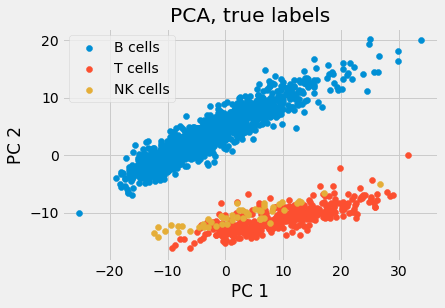

In [11]:
# To see the results of PCA, let's plot the projections and see if they separate by cell type. In this case, we know the
# true labels of cells from the experiment.
plt.scatter(principalComponents[sc_meta['cell_ontology_class'] == 'B cell',0], principalComponents[sc_meta['cell_ontology_class'] == 'B cell',1])
plt.scatter(principalComponents[sc_meta['cell_ontology_class'] == 'T cell',0], principalComponents[sc_meta['cell_ontology_class'] == 'T cell',1])
plt.scatter(principalComponents[sc_meta['cell_ontology_class'] == 'NK cell',0], principalComponents[sc_meta['cell_ontology_class'] == 'NK cell',1])
plt.legend(['B cells','T cells', 'NK cells'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, true labels')
plt.show()

In [12]:
# Now let's use t-SNE, a non-linear dimenstion reduction method which we apply after PCA. You don't need to modify
# anything in this cell.
tsne = TSNE(n_components = 2)
X_embedded = tsne.fit_transform(principalComponents)

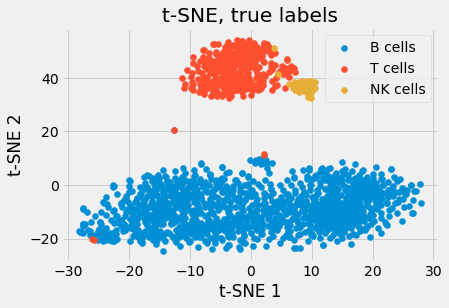

In [13]:
# Now plot the t-SNE embeddings and see what's changed.
plt.scatter(X_embedded[sc_meta['cell_ontology_class'] == 'B cell',0], X_embedded[sc_meta['cell_ontology_class'] == 'B cell',1])
plt.scatter(X_embedded[sc_meta['cell_ontology_class'] == 'T cell',0], X_embedded[sc_meta['cell_ontology_class'] == 'T cell',1])
plt.scatter(X_embedded[sc_meta['cell_ontology_class'] == 'NK cell',0], X_embedded[sc_meta['cell_ontology_class'] == 'NK cell',1])
plt.legend(['B cells','T cells', 'NK cells'])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, true labels')
plt.show()

In [14]:
# We're lucky in our case because we knew the true labels from the experiment. However, we often don't.
# In such a case, the simplest thing to do is something called k-means. This is a clustering algorithm
# which labels the cells as belonging to a cluster once the user specifies the total number of clusters.
# You don't need to modify this cell.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_embedded)
predictions = kmeans.predict(X_embedded)

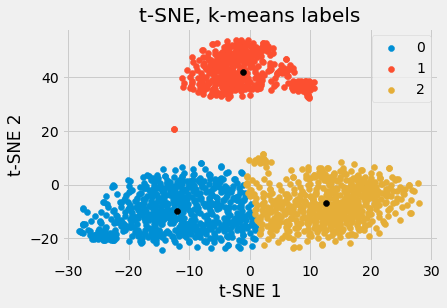

In [15]:
# Let's plot again using the labels from k-means. Do these agree with what we know to be the truth? Run the 
# cell a few times and see what happens. Also feel free to change the number of clusters in the cell above.
plt.scatter(X_embedded[predictions == 0,0], X_embedded[predictions == 0,1])
plt.scatter(X_embedded[predictions == 1,0], X_embedded[predictions == 1,1])
plt.scatter(X_embedded[predictions == 2,0], X_embedded[predictions == 2,1])
plt.legend(['0','1', '2'])
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], color = 'black')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, k-means labels')
plt.show()

In [20]:
# The last step of a standard analysis is typically to identify the marker genes for each cell population. 
# One simple way to do this is to perform a test for each gene which compares its expression in the different cell
# types. Let's find how many genes show evidence of differential expression between B and T cells.
B_ind = list(np.where(sc_meta['cell_ontology_class'] == 'B cell')[0])
T_ind = list(np.where(sc_meta['cell_ontology_class'] == 'T cell')[0])

p_vector = make_array()
for i in np.arange(sc_data_norm.shape[0]):
    p_vector = np.append(p_vector, stats.mannwhitneyu(x=sc_data_norm.iloc[i,B_ind], y=sc_data_norm.iloc[i,T_ind])[1])

n_de_BT = sum(p_vector <= 0.05)
n_de_BT

1573

# Optional: Elbow plot for K-means

An elbow plot is a diagnostic tool which is sometimes used to select the number of clusters in an analysis. Essentially, it plots how well the clustering performs as a function of the number of clusters chosen. Since more clusters always equals better performance, we're looking for the point at which the improvement plateaus. Using this scRNA-seq data set, make an elbow plot with k-means. To generate the plot, you'll want to compute the sum of the squared distance from each point to the appropriate cluster center for each value of k used. Let's do from 1 to 10.

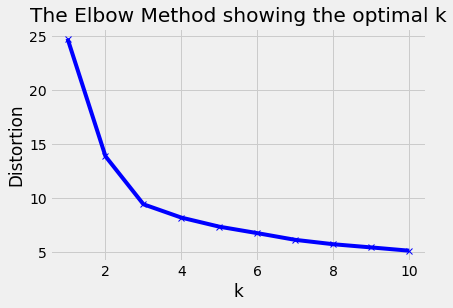

In [84]:
K = range(1,11)
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_embedded)
    kmeanModel.fit(X_embedded)
    distortions.append(sum(np.min(cdist(X_embedded, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_embedded.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()   